# Capstone Project VII - US Arrests


## Exploring the data

In [1]:
#insert data
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv")
df.head()


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [2]:

print('Number of cases: {} Number of features: {}'.format(df.shape[0],df.shape[1]))

Number of cases: 50 Number of features: 5


Summarise the statistical properties of the columns.

In [3]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


Determine any missing values

In [4]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


As we can see, there is no missing data in the dataset.

Next we can determine the type of each data, and plot this as histograms to preview the observations

In [5]:
# Examine types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


We will convert all numerical columns to float for consistency

In [6]:
df["Assault"] = df["Assault"].astype("float")
df["UrbanPop"] = df["Assault"].astype("float")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     float64
 3   UrbanPop  50 non-null     float64
 4   Rape      50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


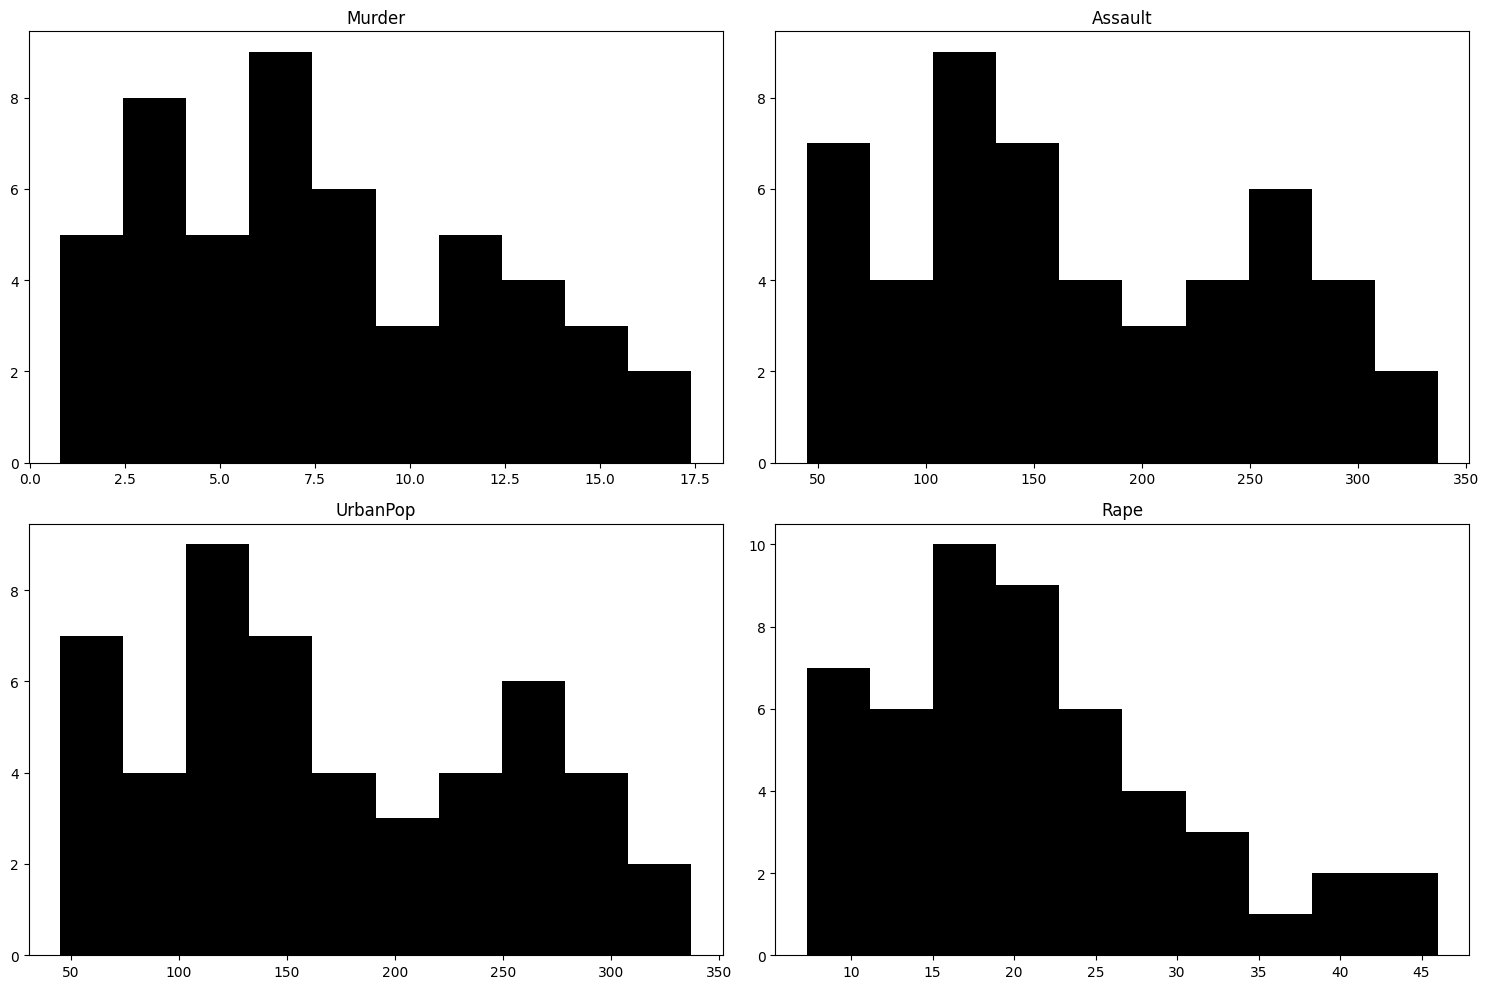

In [7]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10))
plt.tight_layout()
plt.show()


Compile all data to a single dataframe

In [8]:
# Create summary table
frames = [selected_stats]
summary = pd.concat(frames, axis=1)
summary.to_csv('summary.csv', index=True) 
summary

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


All data is in the form of 'per 100,000 residents' or a percentage, so no scaling is needed. 

No imputation is needed either, as there are no missing values.

## Correlation Analysis

A correlation heatmap will be produced to show the correlation between all features.

In [9]:
crime = df.index
corr_df = df.corr()
labels =corr_df.columns

C:\Users\SMIT7430\AppData\Local\Temp\ipykernel_11128\2941688530.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


<AxesSubplot: >

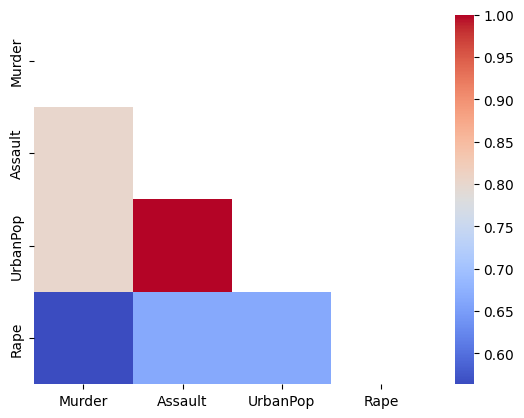

In [10]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

In this plot, it can be seen that levels of assault are very strongly correlated to the level of urban population (close to 1.0). This correlation could be due to urban populations being more densely populated, so therefore more crime would be likely to occur.

Rape and Murder are the two features with the weakest correlation (around 0.6), with Rape and Assault, and Rape and Urban Population also having a relatively weak correlation. The causation behind these figures is not clear.

Murder has a medium-high correlation with Urban Population and Assault, which could be due to more dense populations having a higher likelihood of crime in general, and that areas with high violent crimes such as Murder also being likely to suffer with other violent crimes like Assault.

## PCA

Use PCA to find the underlying variables that best differentiate the observations by determining the directions along which the data points are most spread out.

In [11]:
from sklearn.decomposition import PCA 

np.set_printoptions(precision=2)

X = df.drop(["City"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,92.25,-4.85,2.82,-0.00
1,131.50,16.27,-2.13,0.00
2,174.49,0.39,-4.87,-0.00
3,27.10,-3.16,0.30,0.00
4,149.62,11.36,-3.53,-0.00


In [12]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [1.18e+02 6.99e+00 2.59e+00 1.48e-14]


In [13]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.96e-01 3.49e-03 4.81e-04 1.60e-32]


In [14]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [13941.5  13990.3  13997.03 13997.03]


In [15]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = crime[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

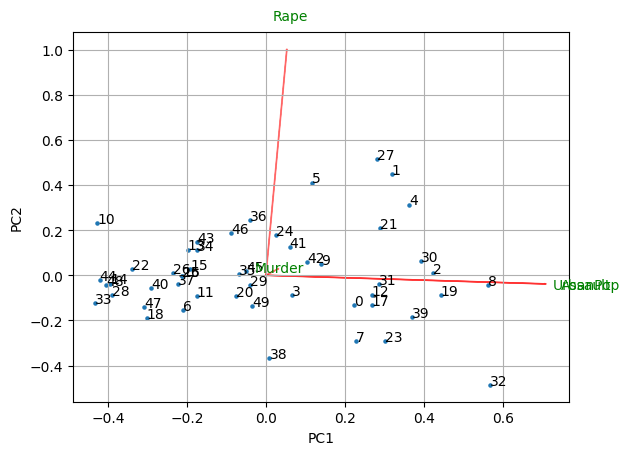

In [16]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(crime))
plt.show()

In [17]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.030,0.027
1,Assault,0.706,0.038
2,UrbanPop,0.706,0.038
3,Rape,0.053,0.998


## Standardise Data

In [18]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,1.457,0.775,0.322,-0.000
1,2.539,-1.610,-0.146,0.000
2,2.094,-0.344,-1.037,-0.000
3,0.283,0.342,-0.041,0.000
4,2.412,-1.265,-0.527,-0.000


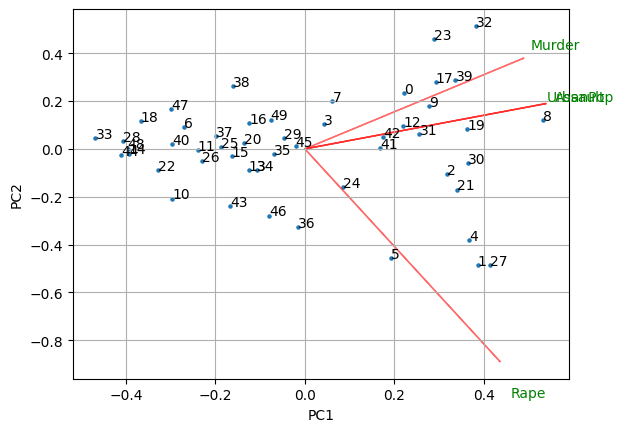

In [19]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

In [20]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.487,0.378
1,Assault,0.536,0.188
2,UrbanPop,0.536,0.188
3,Rape,0.435,0.887


It can be seen that PC1 components contribute relatively evenly.

Understand the contribution of components to variance

Text(0.5, 1.0, 'Cumulative Explained Variance')

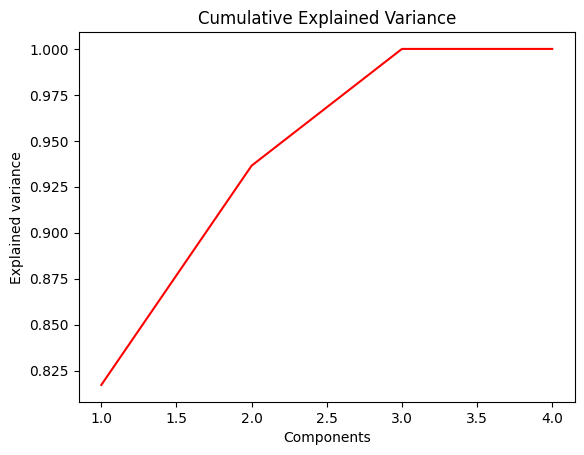

In [22]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

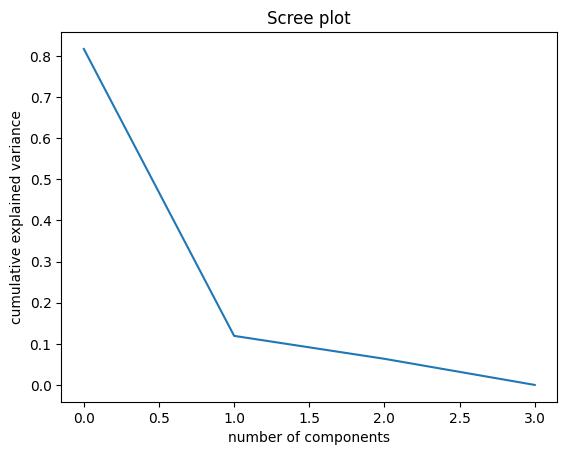

In [23]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

All of the variance is explained with the first 3 components.

In [24]:
pca_df = pd.DataFrame(X_std_trans[:,0:3], index = df.index)
pca_df.head()

,0,1,2
0,1.457,0.775,0.322
1,2.539,-1.610,-0.146
2,2.094,-0.344,-1.037
3,0.283,0.342,-0.041
4,2.412,-1.265,-0.527


## Hierarchical clustering

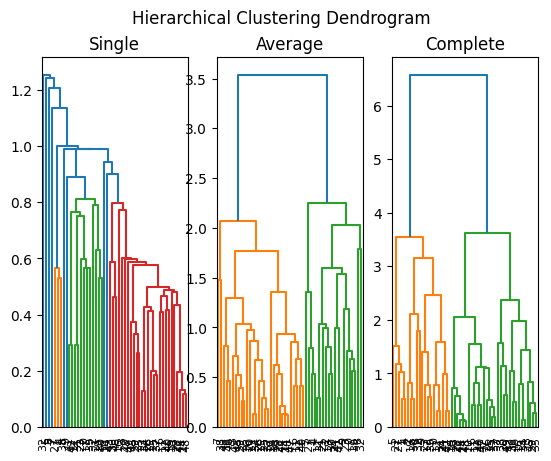

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

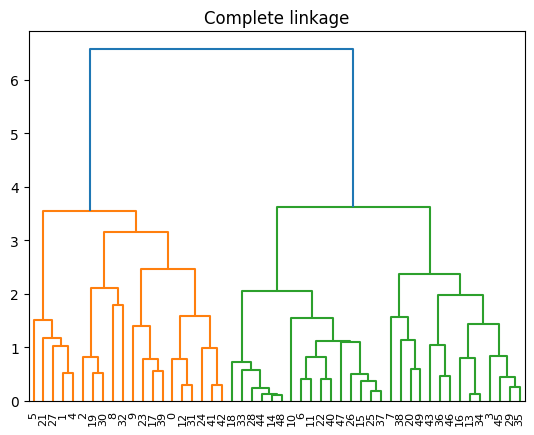

In [27]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

Complete linkage is used as it shows the most distance between the two clusters

### K-means clustering

K-means clustering used for k = 2

C:\Users\SMIT7430\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


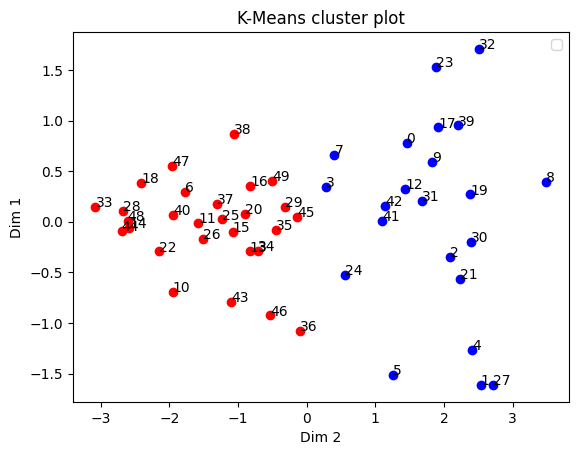

In [28]:


from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=2
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = crime[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [29]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]


group0 = np.array(crime)[group0_indices]
group1 = np.array(crime)[group1_indices]


print("Group 0: {}\n\n".format([df.loc[x]["City"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["City"] for x in group1]))




Group 0: ['Connecticut', 'Hawaii', 'Idaho', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Maine', 'Massachusetts', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'New Jersey', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Dakota', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


Group 1: ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Delaware', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas']


